In [92]:
import os
import numpy as np
import torch
from PIL import Image

In [80]:
import gc
gc.collect()

2982

In [81]:
class VHRDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "positive image set"))))
        self.boxes = list(sorted(os.listdir(os.path.join(self.root, "ground truth"))))
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "positive image set", self.imgs[idx])
        box_path = os.path.join(self.root, "ground truth", self.boxes[idx])
        img = Image.open(img_path).convert("RGB")
        boxes = []
        labels = []
        with open(box_path) as f:
            for line in f:
                if "(" in line:
                    symbols = ["(", ")","\n"," "]
                    for symbol in symbols:
                        line = line.replace(symbol,"") 
                    line = np.array(line.split(',')).astype(np.int64)
                    boxes.append(list(line[:4]))
                    labels.append(line[len(line)-1])
                else:
                    break
        num_objs = len(boxes)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)   
        return img, target
    def __len__(self):
        return len(self.imgs)

In [82]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def initialize_faster_rcnn_model(model_name, num_classes, pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    if model_name.find("fpn")>0:
        if model_name == "resnet50_fpn":
            # load a model pre-trained pre-trained on COCO
            model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)

        elif model_name == "mobilenet_v3_large_fpn":
            model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=pretrained)

        elif model_name == "mobilenet_v3_large_320_fpn":
            model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=pretrained)

        else:
            print("Invalid model name, exiting...")
            exit()
            
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    else:
        if model_name == "mobilenet_v2":
            backbone = torchvision.models.mobilenet_v2(pretrained=True).features
            backbone.out_channels = 1280
        elif model_name == "mobilenet_v3_large":
            backbone = torchvision.models.mobilenet_v3_large(pretrained=True).features
            backbone.out_channels = 960
        elif model_name == "mobilenet_v3_small":
            backbone = torchvision.models.mobilenet_v3_small(pretrained=True).features
            backbone.out_channels = 576
            
        anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

        roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

        model = FasterRCNN(backbone,
                           num_classes=num_classes,
                           rpn_anchor_generator=anchor_generator,
                           box_roi_pool=roi_pooler)

    return model

# get the model using our helper function
model = initialize_faster_rcnn_model("mobilenet_v3_small",11)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


In [83]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def get_faster_rcnn(num_classes):
    # load a pre-trained model for classification and return
    # only the features
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    # FasterRCNN needs to know the number of
    # output channels in a backbone. For mobilenet_v2, it's 1280
    # so we need to add it here
    backbone.out_channels = 1280

    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))

    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                       num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)
    return model

In [84]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [85]:
import torch_utils.transforms as T
import torch_utils.utils as utils


def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [86]:
dataset = VHRDataset('NWPU VHR-10 dataset', get_transform(train=False))
dataset_test = VHRDataset('NWPU VHR-10 dataset', get_transform(train=False))

In [87]:
for im_idx in range(len(dataset)):
    img, target = dataset[im_idx]
img, target = dataset[434]
print(img.shape, '\n',target)

torch.Size([3, 711, 1090]) 
 {'boxes': tensor([[1007.,  496., 1039.,  538.],
        [ 951.,  390.,  989.,  438.],
        [ 888.,  284.,  923.,  331.],
        [ 241.,  161.,  288.,  203.],
        [ 101.,  597.,  150.,  646.],
        [ 359.,   71.,  402.,  109.],
        [ 794.,  124.,  832.,  161.],
        [ 830.,  188.,  867.,  227.],
        [ 860.,  234.,  896.,  278.],
        [ 981.,  449., 1021.,  492.]]), 'labels': tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10]), 'image_id': tensor([434]), 'area': tensor([1344., 1824., 1645., 1974., 2401., 1634., 1406., 1443., 1584., 1720.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


In [88]:
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

In [89]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [90]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 11
#model = get_object_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
from torch_utils.engine import train_one_epoch, evaluate
# training for 10 epochs
num_epochs = 15

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

In [91]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

Epoch: [0]  [ 0/52]  eta: 0:00:47  lr: 0.000103  loss: 3.1887 (3.1887)  loss_classifier: 2.4469 (2.4469)  loss_box_reg: 0.0281 (0.0281)  loss_objectness: 0.6879 (0.6879)  loss_rpn_box_reg: 0.0258 (0.0258)  time: 0.9132  data: 0.6168  max mem: 15751
Epoch: [0]  [10/52]  eta: 0:00:14  lr: 0.001082  loss: 2.9014 (2.7059)  loss_classifier: 2.1611 (1.9538)  loss_box_reg: 0.0509 (0.0465)  loss_objectness: 0.6827 (0.6803)  loss_rpn_box_reg: 0.0219 (0.0253)  time: 0.3488  data: 0.0761  max mem: 15751
Epoch: [0]  [20/52]  eta: 0:00:10  lr: 0.002062  loss: 1.6525 (2.0119)  loss_classifier: 0.9535 (1.3022)  loss_box_reg: 0.0409 (0.0423)  loss_objectness: 0.6520 (0.6436)  loss_rpn_box_reg: 0.0216 (0.0238)  time: 0.2926  data: 0.0237  max mem: 15751
Epoch: [0]  [30/52]  eta: 0:00:06  lr: 0.003041  loss: 1.1408 (1.6945)  loss_classifier: 0.5234 (1.0527)  loss_box_reg: 0.0314 (0.0369)  loss_objectness: 0.5233 (0.5821)  loss_rpn_box_reg: 0.0210 (0.0227)  time: 0.2887  data: 0.0257  max mem: 15751
Epoc

In [93]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

tensor([716.,  23., 844., 112.])
tensor([399., 115., 448., 186.])
tensor([348., 115., 401., 189.])
tensor([289., 361., 397., 457.])


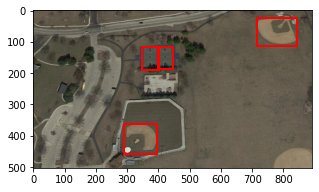

In [94]:
# Function to visualize bounding boxes in the image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    im = img.cpu().detach().numpy()
    im = im.transpose((1, 2, 0))
    a.imshow(im)
    for box in (target['boxes']):
        print(box)
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset_test[21]
plot_img_bbox(img, target)

In [95]:
# pick one image from the test set
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  24
real #boxes:  4


MODEL OUTPUT
[731.51044   13.147752 824.27      98.08648 ]
[752.89154   40.190178 831.6923   115.45085 ]
[789.7965    72.419624 840.6376   110.85641 ]
[733.60864     1.7320848 864.66705   113.61763  ]
[287.8345  364.72375 387.40613 451.99652]
[791.99164   41.496582 831.38806   90.799385]
[803.59033  65.54046 854.2389   98.60954]
[706.79755   33.005688 752.15295   72.82437 ]
[300.49268 388.3308  354.79858 435.68216]
[775.1067    43.611206 816.937     96.43831 ]
[691.7153    16.866068 771.0962   100.9357  ]
[761.9035    31.034468 858.9711   102.00763 ]
[788.2858    20.404263 843.1497    58.959354]
[736.5755      3.0327656 866.6856    112.48341  ]
[786.683     49.391724 841.1646    78.88845 ]
[716.3301    43.090424 773.80756   77.38657 ]
[753.737     51.96718  823.27747   85.885994]
[732.11804   30.848259 770.0503    68.70713 ]
[772.45575   24.610771 807.29297   75.56139 ]
[323.23395 368.80084 422.63486 442.68835]
[783.7963    18.421736 858.7975    94.4889  ]
[759.42334     1.3618063 846.

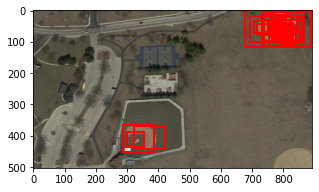

In [96]:
#1
print('MODEL OUTPUT')
from copy import deepcopy
pred = deepcopy(prediction)
pred['boxes']= pred['boxes'].cpu().numpy()
plot_img_bbox(img, pred)

In [97]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)

NMS APPLIED MODEL OUTPUT
[731.51044   13.147752 824.27      98.08648 ]
[789.7965    72.419624 840.6376   110.85641 ]
[287.8345  364.72375 387.40613 451.99652]
[706.79755   33.005688 752.15295   72.82437 ]
[788.2858    20.404263 843.1497    58.959354]
[786.683     49.391724 841.1646    78.88845 ]


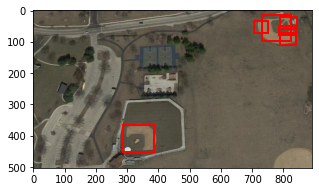

In [98]:
print('NMS APPLIED MODEL OUTPUT')
nms_prediction['boxes']= nms_prediction['boxes'].cpu().numpy()
plot_img_bbox(img, nms_prediction)

In [124]:
prediction

{'boxes': array([[590.71063 , 439.12778 , 638.9808  , 499.1951  ],
        [624.80096 , 198.09639 , 683.7445  , 256.73273 ],
        [202.58446 , 192.18872 , 268.19058 , 262.37338 ],
        [145.87376 , 426.62723 , 241.6632  , 524.5657  ],
        [ 64.958885, 185.5825  , 146.78207 , 263.34824 ],
        [ 28.368946, 412.84503 , 102.678955, 500.4982  ],
        [368.5355  , 425.12253 , 439.14502 , 516.66705 ],
        [297.15662 , 193.2166  , 360.8369  , 259.2481  ],
        [266.09412 , 423.9959  , 343.19583 , 510.09955 ],
        [448.78952 , 196.84143 , 509.01782 , 253.12073 ],
        [376.94086 , 198.06436 , 434.06012 , 257.71436 ],
        [106.37908 , 255.27087 , 150.77846 , 301.55017 ],
        [171.0624  , 242.83836 , 194.76018 , 300.39352 ],
        [537.3171  , 230.70102 , 568.0751  , 297.78705 ],
        [307.0119  , 397.74503 , 343.3365  , 433.24265 ],
        [683.2512  , 397.65863 , 736.5078  , 453.0269  ]], dtype=float32),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [125]:
target

{'boxes': tensor([[ 66., 186., 142., 272.],
         [204., 191., 268., 260.],
         [297., 190., 361., 261.],
         [374., 197., 433., 255.],
         [448., 199., 505., 251.],
         [621., 194., 686., 256.],
         [ 27., 417., 104., 501.],
         [142., 419., 242., 524.],
         [262., 420., 341., 510.],
         [364., 422., 443., 518.],
         [587., 438., 641., 501.]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'image_id': tensor([28]),
 'area': tensor([ 6536.,  4416.,  4544.,  3422.,  2964.,  4030.,  6468., 10500.,  7110.,
          7584.,  3402.]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [74]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False